$$
\begin{aligned}
V(\rho, \tau) = \max
    \left\{
        \begin{array}{ll}
            p q\Delta t  + \delta V(\rho, \tau), & \mbox{action = AL} \\[0.5ex]
            p_h q \rho \Delta t + \delta \big[p_h q \rho \Delta t V(1, \tau)  + (1-p_h q \rho \Delta t) V(\rho_L(\Delta t), \tau)\big], & \mbox{action = BL} \\[0.5ex]
            p q_h \tau \Delta t + \delta \big[p q_h \tau \Delta t V(\rho, 1)  + (1-p q_h \tau \Delta t) V(\rho, \tau_L(\Delta t))\big], & \mbox{action = AR} \\[0.5ex]
            p_h q_h\rho\tau \Delta t + \delta \big[p_h q_h\rho\tau \Delta t V(1,1)  + (1-p_h q_h\rho\tau \Delta t) V(\rho_{LL}(\Delta t), \tau_{LL}(\Delta t) ) \big],& \mbox{action = BR}
        \end{array}
    \right.
\end{aligned}
$$ 


$$
\begin{aligned}
    \delta ={}&  1 - r \Delta t \\[0.5ex]
    \rho_L(\Delta t) ={}& \frac{\rho(1- p_h q \Delta t )}{1- p_h q \rho \Delta t} \\[0.5ex] 
    \tau_L(\Delta t) ={}& \frac{\tau(1- pq_h\Delta t)}{1- p q_h\tau \Delta t } \\[0.5ex] 
    \rho_{LL}(\Delta t ) ={}& \frac{\rho(1- p_h q_h \tau \Delta t )}{1- p_h q_h \rho \tau \Delta t}\\[0.5ex]
    \tau_{LL}(\Delta t) ={}& \frac{\tau (1 - p_h q_h \rho \Delta t)}{1 - p_h q_h \rho \tau \Delta t}
\end{aligned}
$$

In [1]:
import numpy as np 
import pyomo.environ as pe

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import plotly.graph_objects as go

In [71]:
# p < ph, q < qh
# p, q, ph, qh = 0.4, 0.5, 0.6, 0.9 

r = 0.1 # discount rat 
dt = 0.01 # time discretimization step
delta = 1 - r*dt
N = 201 # size of 1-d grid 
rho = np.linspace(0, 1, N)
tau = np.linspace(0, 1, N)

In [170]:
p, q = np.random.uniform(0.1, 0.9, 2)
ph = np.random.uniform(p, 0.9)
qh = np.random.uniform(q, 0.9)
p, q, ph, qh

(0.49960696641927826,
 0.6164930476419423,
 0.9180974465146741,
 0.8314043996828595)

In [171]:
model = pe.ConcreteModel()
model.V = pe.Var(range(N), range(N), domain=pe.Reals)
model.obj = pe.Objective(expr=sum(model.V[i,j] for i in range(N) for j in range(N)),
                        sense=pe.minimize)

def rule_AL(m, i, j):    
    return m.V[i,j] >= dt*p*q + delta*m.V[i,j]  
model.const_AL = pe.Constraint(range(N), range(N), rule=rule_AL)

def rule_BL(m, i, j):  
    tmp = dt*rho[i]*ph*q
    rho_l = (rho[i] - tmp)/(1 - tmp)
    h = round(rho_l*(N-1))
    return m.V[i,j] >= tmp + delta*(tmp*m.V[N-1,j] + (1-tmp)*m.V[h,j])
model.const_BL = pe.Constraint(range(N), range(N), rule=rule_BL)

def rule_AR(m, i, j):    
    tmp = dt*tau[j]*p*qh
    tau_l = (tau[j] - tmp)/(1 - tmp)
    k = round(tau_l*(N-1))
    return m.V[i,j] >= tmp + delta*(tmp*m.V[i,N-1] + (1-tmp)*m.V[i,k])
model.const_AR = pe.Constraint(range(N), range(N), rule=rule_AR)

def rule_BR(m, i, j):  
    tmp = dt*rho[i]*tau[j]*ph*qh
    rho_ll = (rho[i] - tmp)/(1 - tmp)
    tau_ll = (tau[j] - tmp)/(1 - tmp)
    h = round(rho_ll*(N-1))
    k = round(tau_ll*(N-1))
    return m.V[i,j] >= tmp + delta*(tmp*m.V[N-1,N-1] + (1-tmp)*m.V[h,k])
model.const_BR = pe.Constraint(range(N), range(N), rule=rule_BR)

solver = pe.SolverFactory('gurobi')
solver.solve(model);

In [172]:
val_func = np.empty((N,N))
for i in range(N):
    for j in range(N):
        val_func[i,j] = model.V[i,j]()

In [173]:
results = np.empty((N,N,4))
for i in range(N):
    for j in range(N):
        results[i,j,0] = model.const_AL[i,j].body() 
        results[i,j,1] = model.const_BL[i,j].body() 
        results[i,j,2] = model.const_AR[i,j].body() 
        results[i,j,3] = model.const_BR[i,j].body() 
policy = results.argmax(axis=2)


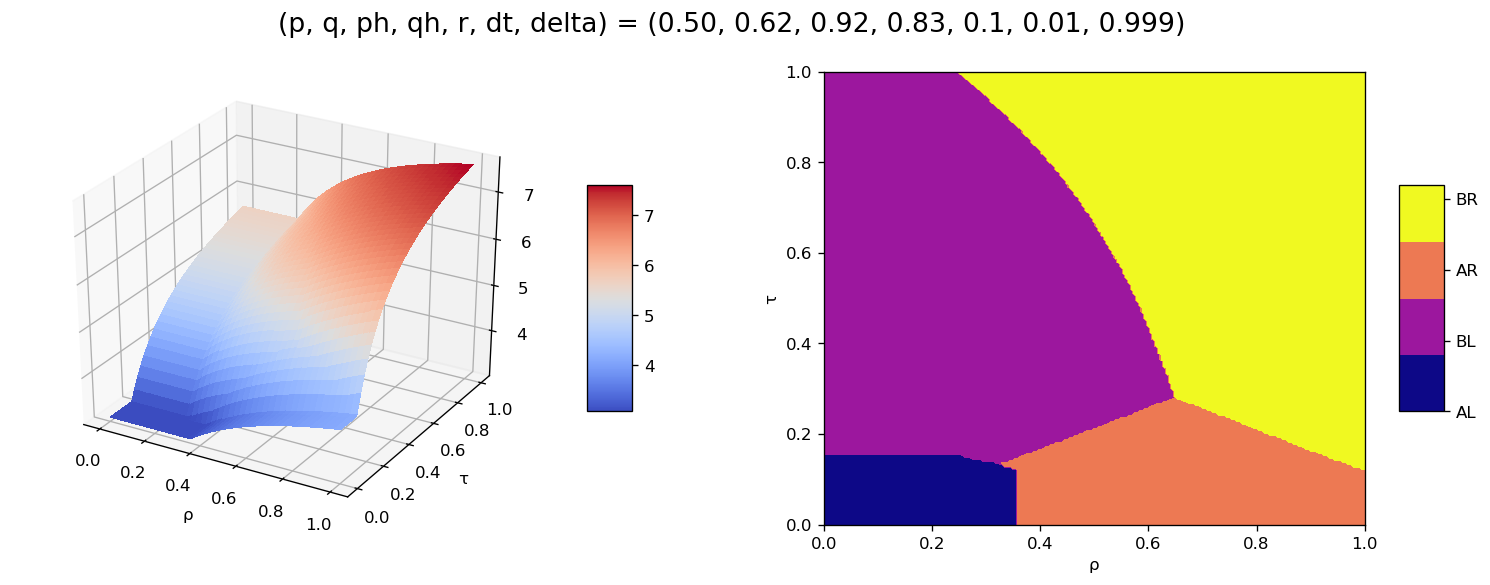

In [174]:
fig = plt.figure(figsize=(16,5), dpi=120)
fig.suptitle('(p, q, ph, qh, r, dt, delta) = ({:3.2f}, {:3.2f}, {:3.2f}, {:3.2f}, {}, {}, {})'.format(p,q,ph,qh,r,dt,delta), 
             fontsize=16)

ax0 = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(rho, tau)
surf = ax0.plot_surface(X, Y, val_func, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax0.set_xlabel('ρ')
ax0.set_ylabel('τ')
fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax0)

ax1 = fig.add_subplot(1, 2, 2)
cont = ax1.contourf(X, Y, policy, cmap=cm.get_cmap('plasma', 4))
actions = ['AL', 'BL', 'AR', 'BR']
formatter = plt.FuncFormatter(lambda val, loc: actions[val])
ax1.set_xlabel('ρ')
ax1.set_ylabel('τ')
fig.colorbar(cont, ticks=range(4), format=formatter, ax=ax1, shrink=0.5, aspect=5)

# fig.savefig('r_{}.png'.format(r))

In [175]:
fig = go.Figure(data=[go.Surface(z=val_func, x=rho, y=tau, 
                                 colorscale='aggrnyl', showscale=False)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Value Function', autosize=True,
                  width=600, height=600,
                  scene_aspectmode='cube'
)

fig.show()